In [1]:
import pandas as pd
import numpy as np

# Hela ML libraries 
from hela import hmm
import hela.generation.hmm as hmm_gen

# Viz libraries
import altair as alt
import hela.visualization.hmm as hmmplot 
import matplotlib.pyplot as plt
from hela.visualization.hmm import TU_COLORS
%matplotlib inline

# Utility Libraries
from datetime import datetime
from dask.distributed import Client
from scipy.special import logsumexp
from scipy import stats
import itertools
LOG_ZERO = -1e8

# Generate Data

We begin by generation fhmm type data using the generative modeling tools in hela.

In [2]:
gen = hmm_gen.FactoredHMMGenerativeModel(
                                     ns_hidden_states =[2,3],
                                     n_gaussian_features =2,
                                     n_categorical_features = 2)

factored_hidden_states = gen.generate_hidden_state_sequence(n_observations = 500)
factored_hidden_states.head()

,0,1
2020-08-01,1,2
2020-08-02,1,2
2020-08-03,1,2
2020-08-04,1,2
2020-08-05,1,2


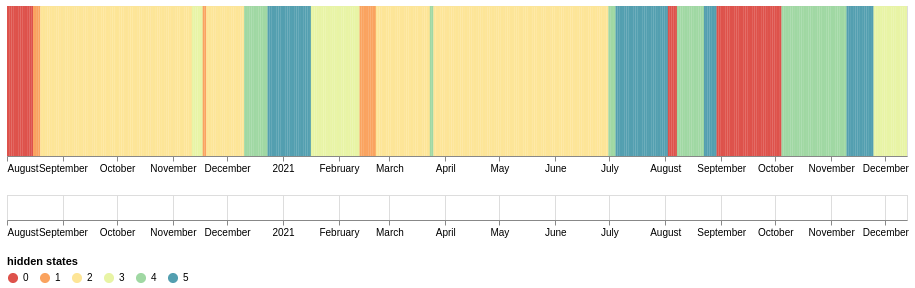

In [3]:
flattened_hidden_states = gen.flatten_hidden_state_sequence(factored_hidden_states)
hmmplot.draw_states(flattened_hidden_states, hide_brush=False)

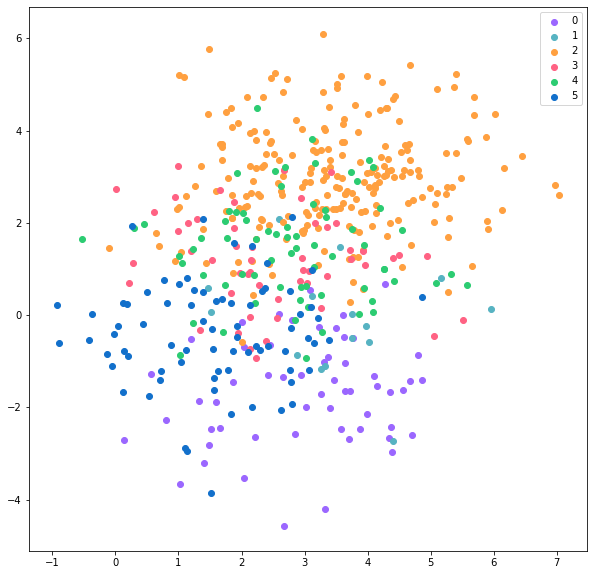

In [4]:
data = gen.generate_observations(factored_hidden_states)

plt.figure(figsize = (10,10))
feat = gen.gaussian_values.columns
for i in range(np.prod(gen.ns_hidden_states)):
    idx = np.where(flattened_hidden_states == i)
    df = np.array(data.loc[data.index[idx],feat])
    plt.scatter([d[0] for d in df],[d[1] for d in df], color = TU_COLORS[i],label = i)

plt.legend()
plt.show()

# Load Model

In [5]:
fhmm_training_spec = hmm_gen.data_to_fhmm_training_spec(factored_hidden_states, 
                                   gen.ns_hidden_states, 
                                   data,
                                   categorical_features = list(gen.categorical_values.columns), 
                                   gaussian_features = list(gen.gaussian_values.columns)
                                                       )

fhmm_config = hmm.FactoredHMMConfiguration.from_spec(fhmm_training_spec)
untrained_fhmm_model = fhmm_config.to_model()

# Train Model

### Train with Structured VI

In [6]:
vi_alg = untrained_fhmm_model.load_learning_interface()
vi_model = vi_alg.run(
    data=data,
    method='structured_vi',
    training_iterations=10)

In [7]:
vi_likelihood = []
for m in vi_alg.model_results:
    spec = hmm._factored_hmm_to_discrete_hmm(m)
    hmm_config = hmm.DiscreteHMMConfiguration.from_spec(spec)
    hmm_model = hmm_config.to_model()
    hmm_inf = hmm_model.load_inference_interface()
    log_prob = hmm_inf.predict_hidden_state_log_probability(data)
    vi_likelihood.append(
            logsumexp(hmm_inf._compute_forward_probabilities(log_prob)[-1]))

### Train with Gibbs Sampling

In [8]:
gibbs_alg = untrained_fhmm_model.load_learning_interface()
gibbs_model = gibbs_alg.run(
    data=data,
    method='gibbs',
    training_iterations=10,
    gibbs_iterations = 5)

In [9]:
gibbs_likelihood = []
for m in gibbs_alg.model_results:
    spec = hmm._factored_hmm_to_discrete_hmm(m)
    hmm_config = hmm.DiscreteHMMConfiguration.from_spec(spec)
    hmm_model = hmm_config.to_model()
    hmm_inf = hmm_model.load_inference_interface()
    log_prob = hmm_inf.predict_hidden_state_log_probability(data)
    gibbs_likelihood.append(
            logsumexp(hmm_inf._compute_forward_probabilities(log_prob)[-1]))

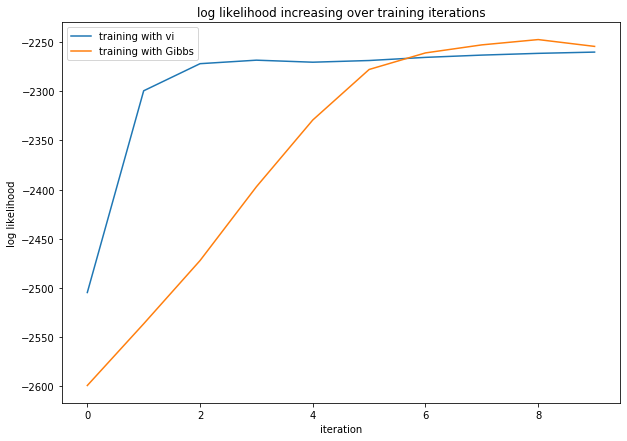

In [10]:
plt.figure(figsize = (10,7))
plt.plot([t for t in range(len(vi_likelihood))],vi_likelihood, label = "training with vi")
plt.plot([t for t in range(len(gibbs_likelihood))],gibbs_likelihood, label = "training with Gibbs")

plt.title("log likelihood increasing over training iterations")
plt.ylabel("log likelihood")
plt.xlabel("iteration")
plt.legend()
plt.show()

# Infer Hidden States

### True hidden states

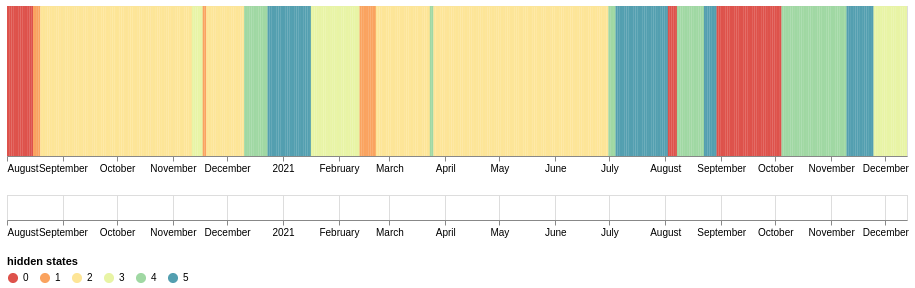

In [11]:
flattened_hidden_states = gen.flatten_hidden_state_sequence(factored_hidden_states)
hmmplot.draw_states(flattened_hidden_states, hide_brush=False)

### Inference with Viterbi and VI

In [16]:
inf = vi_model.load_inference_interface(data)

# randomly initialize variational parameters
h_t = np.random.rand(len(data), 
                        len(vi_model.ns_hidden_states), 
                        np.max(vi_model.ns_hidden_states))

# Log forward-backward
h_ts = [h_t]
for i in range(5):
    gamma, alpha, beta = inf.log_forward_backward(h_t)
    h_t = inf.h_t_update(gamma, data)
    h_ts.append(h_t)
    
log_path = inf.predict_hidden_states_log_viterbi(h_ts[-1])

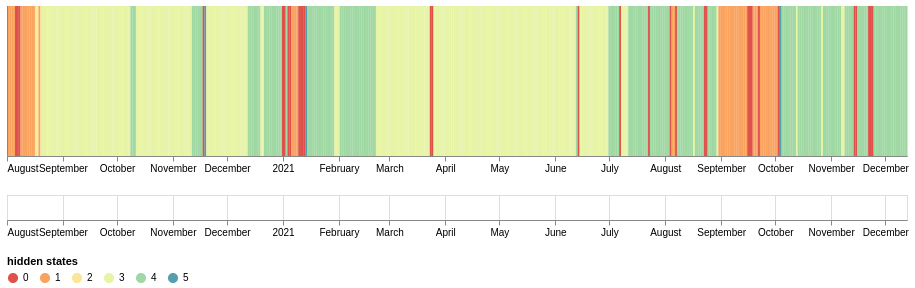

In [17]:
flattened_pred_states = gen.flatten_hidden_state_sequence(log_path)
hmmplot.draw_states(flattened_pred_states, hide_brush=False)

In [33]:
p_any = np.sum(np.any(np.array(log_path) == np.array(factored_hidden_states), axis = 1)) / data.shape[0]
p_all = np.sum(np.all(np.array(log_path) == np.array(factored_hidden_states), axis = 1)) / data.shape[0]

print("{}% of the time VI returned the correct hidden state for at least one system.".format(int(p_any *100)))
print("")
print("{}% of the time VI returned the correct hidden state for every system.".format(int(p_all *100)))

94% of the time VI returned the correct hidden state for at least one system.

13% of the time VI returned the correct hidden state for every system.


### Inference with Gibbs sampling

In [18]:
inf = gibbs_model.load_inference_interface(data)

Gamma, Xi, hidden_state_vector_df = inf.gibbs_sampling(data,
                                                       iterations = 50,
                                                       burn_down_period=0)


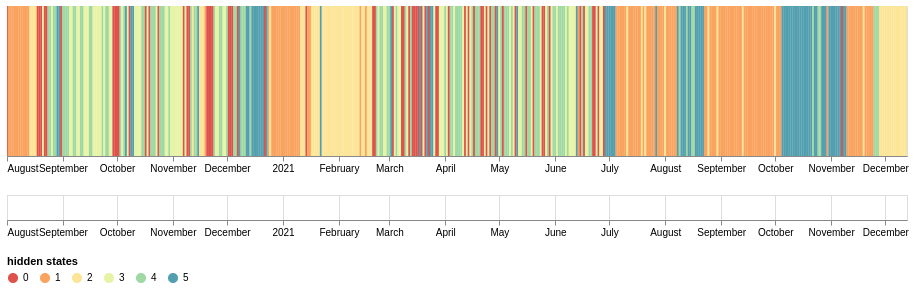

In [19]:
flattened_pred_states = gen.flatten_hidden_state_sequence(hidden_state_vector_df)
hmmplot.draw_states(flattened_pred_states, hide_brush=False)

In [25]:
p_any = np.sum(np.any(np.array(hidden_state_vector_df) == np.array(factored_hidden_states), axis = 1)) / data.shape[0]
p_all = np.sum(np.all(np.array(hidden_state_vector_df) == np.array(factored_hidden_states), axis = 1)) / data.shape[0]

print("{}% of the time Gibbs returned the correct hidden state for at least one system.".format(int(p_any *100)))
print("")
print("{}% of the time VI returned the correct hidden state for every system.".format(int(p_all *100)))

0.942

In [26]:
np.sum(np.any(np.array(hidden_state_vector_df) == np.array(factored_hidden_states), axis = 1)) / data.shape[0]

0.862